In [ ]:
!pip install openai
!pip install captum
!pip install fvcore

import math
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from copy import deepcopy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split, Subset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

from captum.attr import IntegratedGradients
from fvcore.nn import FlopCountAnalysis, flop_count_table, parameter_count_table
import openai


from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
import numpy as np

In [ ]:
%env OPENAI_API_KEY= None # to be added
openai.api_key = os.getenv("OPENAI_API_KEY")

In [ ]:
# Global variable for the model
MODEL = "gpt-4o"
GEN_TEMPERTURE = 0.0
ACC_TEMPERTURE = 0.0

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Outer Iteration 1/5

        
    Common PyTorch layer definitions:
    1. Convolutional Layer:
       {"type": "Conv2d", "in_channels": "3", "out_channels": "64", "kernel_size": "3", "stride": "1", "padding": "1"}
    2. Linear (Fully Connected) Layer:
       {"type": "Linear", "in_features": "512", "out_features": "256"}
    3. ReLU Activation:
       {"type": "ReLU"}
    4. Max Pooling:
       {"type": "MaxPool2d", "kernel_size": "2", "stride": "2"}
    5. Dropout:
       {"type": "Dropout", "p": "0.5"}
    6. Batch Normalization:
       {"type": "BatchNorm2d", "num_features": "64"}
    7. Flatten:
       {"type": "Flatten"}
    8. Adaptive Average Pooling:
       {"type": "AdaptiveAvgPool2d", "output_size": "(1, 1)"}
    Remember to use string values for all numerical parameters.
    

        Generate an initial model definition for a dataset with the following characteristics:
        Input shape: (1, 8, 8), Classes: 10

        The output should be a JSON-serializable dictionary

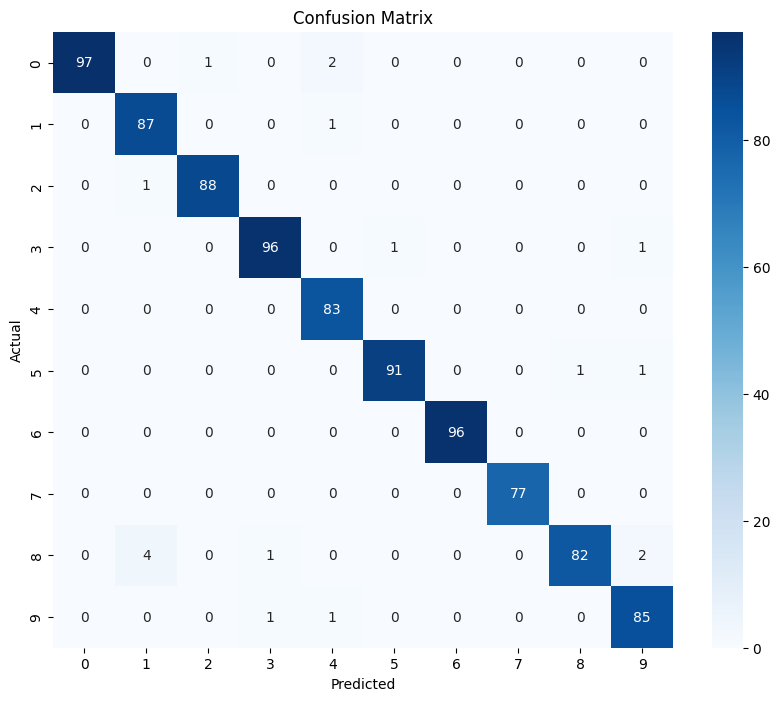

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       100
           1       0.95      0.99      0.97        88
           2       0.99      0.99      0.99        89
           3       0.98      0.98      0.98        98
           4       0.95      1.00      0.98        83
           5       0.99      0.98      0.98        93
           6       1.00      1.00      1.00        96
           7       1.00      1.00      1.00        77
           8       0.99      0.92      0.95        89
           9       0.96      0.98      0.97        87

    accuracy                           0.98       900
   macro avg       0.98      0.98      0.98       900
weighted avg       0.98      0.98      0.98       900

Layer-wise FLOPs:
| module     | #parameters or shape   | #flops   |
|:-----------|:-----------------------|:---------|
| model      | 13.706K                | 91.776K  |
|  0         |  0.16K                 |  9.216K  |
|   0.weight |   (1

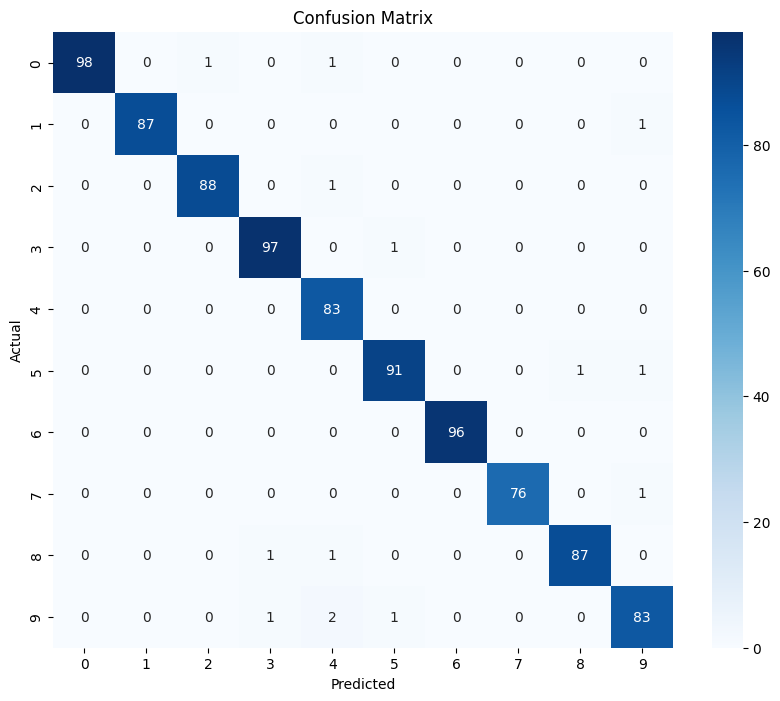

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       100
           1       1.00      0.99      0.99        88
           2       0.99      0.99      0.99        89
           3       0.98      0.99      0.98        98
           4       0.94      1.00      0.97        83
           5       0.98      0.98      0.98        93
           6       1.00      1.00      1.00        96
           7       1.00      0.99      0.99        77
           8       0.99      0.98      0.98        89
           9       0.97      0.95      0.96        87

    accuracy                           0.98       900
   macro avg       0.98      0.98      0.98       900
weighted avg       0.98      0.98      0.98       900

Layer-wise FLOPs:
| module      | #parameters or shape   | #flops   |
|:------------|:-----------------------|:---------|
| model       | 60.81K                 | 0.361M   |
|  0          |  0.32K                 |  18.432K |
|   0.weight  |

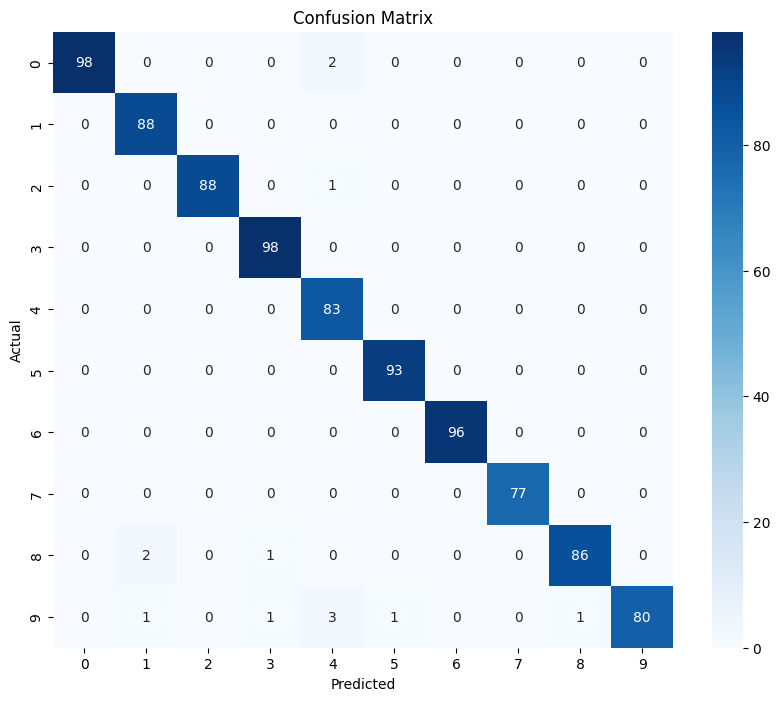

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       100
           1       0.97      1.00      0.98        88
           2       1.00      0.99      0.99        89
           3       0.98      1.00      0.99        98
           4       0.93      1.00      0.97        83
           5       0.99      1.00      0.99        93
           6       1.00      1.00      1.00        96
           7       1.00      1.00      1.00        77
           8       0.99      0.97      0.98        89
           9       1.00      0.92      0.96        87

    accuracy                           0.99       900
   macro avg       0.99      0.99      0.99       900
weighted avg       0.99      0.99      0.99       900

Layer-wise FLOPs:
| module      | #parameters or shape   | #flops   |
|:------------|:-----------------------|:---------|
| model       | 0.24M                  | 1.394M   |
|  0          |  0.64K                 |  36.864K |
|   0.weight  |

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x256 and 1024x512)

In [ ]:
class LLMModelTrainer:
    LAYER_EXAMPLES = """
    Common PyTorch layer definitions:
    1. Convolutional Layer:
       {"type": "Conv2d", "in_channels": "3", "out_channels": "64", "kernel_size": "3", "stride": "1", "padding": "1"}
    2. Linear (Fully Connected) Layer:
       {"type": "Linear", "in_features": "512", "out_features": "256"}
    3. ReLU Activation:
       {"type": "ReLU"}
    4. Max Pooling:
       {"type": "MaxPool2d", "kernel_size": "2", "stride": "2"}
    5. Dropout:
       {"type": "Dropout", "p": "0.5"}
    6. Batch Normalization:
       {"type": "BatchNorm2d", "num_features": "64"}
    7. Flatten:
       {"type": "Flatten"}
    8. Adaptive Average Pooling:
       {"type": "AdaptiveAvgPool2d", "output_size": "(1, 1)"}
    Remember to use string values for all numerical parameters.
    """

    def __init__(self, train_loader, val_loader, class_names, model=MODEL, dataset_description="", epochs=10, device='cpu', metric_weights={'accuracy': 0.25, 'precision': 0.25, 'recall': 0.25, 'f1': 0.25}, flops_weight=0.1):
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.class_names = class_names
        self.model = model
        self.epochs = epochs
        self.device = device
        self.model_results = []
        self.current_model_id = 0
        self.dataset_description = dataset_description
        self.client = openai.OpenAI(api_key=openai.api_key)
        self.metric_weights = metric_weights
        self.flops_weight = flops_weight

    def create_model(self, layers):
        layer_list = []
        for layer in layers:
            layer_type = layer.get("type")
            if layer_type == "Linear":
                in_features = int(layer.get("in_features"))
                out_features = int(layer.get("out_features"))
                bias = layer.get("bias", True)
                layer_list.append(nn.Linear(in_features, out_features, bias))
            elif layer_type == "Conv2d":
                in_channels = int(layer.get("in_channels"))
                out_channels = int(layer.get("out_channels"))
                kernel_size = int(layer.get("kernel_size"))
                stride = int(layer.get("stride", 1))
                padding = int(layer.get("padding", 0))
                layer_list.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))
            elif layer_type == "ReLU":
                layer_list.append(nn.ReLU())
            elif layer_type == "MaxPool2d":
                kernel_size = int(layer.get("kernel_size"))
                stride = int(layer.get("stride", None))
                padding = int(layer.get("padding", 0))
                layer_list.append(nn.MaxPool2d(kernel_size, stride, padding))
            elif layer_type == "Dropout":
                p = float(layer.get("p", 0.5))
                layer_list.append(nn.Dropout(p))
            elif layer_type == "BatchNorm2d":
                num_features = int(layer.get("num_features"))
                layer_list.append(nn.BatchNorm2d(num_features))
            elif layer_type == "Flatten":
                layer_list.append(nn.Flatten())
            elif layer_type == "AdaptiveAvgPool2d":
                output_size = eval(layer.get("output_size"))
                layer_list.append(nn.AdaptiveAvgPool2d(output_size))
        return nn.Sequential(*layer_list)

    def setup_training(self, model, learning_rate=0.001, optimizer_type='Adam', loss_function_type='CrossEntropyLoss', scheduler_type=None, scheduler_params=None):
        if loss_function_type == 'CrossEntropyLoss':
            loss_function = nn.CrossEntropyLoss()
        elif loss_function_type == 'MSELoss':
            loss_function = nn.MSELoss()
        else:
            raise ValueError(f"Unsupported loss function type: {loss_function_type}")

        if optimizer_type == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        elif optimizer_type == 'SGD':
            optimizer = optim.SGD(model.parameters(), lr=learning_rate)
        else:
            raise ValueError(f"Unsupported optimizer type: {optimizer_type}")

        scheduler = None
        if scheduler_type is not None:
            if scheduler_type == 'StepLR':
                step_size = scheduler_params.get('step_size', 30)
                gamma = scheduler_params.get('gamma', 0.1)
                scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
            elif scheduler_type == 'ReduceLROnPlateau':
                mode = scheduler_params.get('mode', 'min')
                factor = scheduler_params.get('factor', 0.1)
                patience = scheduler_params.get('patience', 10)
                scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode=mode, factor=factor, patience=patience)
            else:
                raise ValueError(f"Unsupported scheduler type: {scheduler_type}")

        return optimizer, loss_function, scheduler

    def evaluate_model(self, accuracy, precision, recall, f1, flops):
        performance_score = (
            self.metric_weights['accuracy'] * accuracy +
            self.metric_weights['precision'] * precision +
            self.metric_weights['recall'] * recall +
            self.metric_weights['f1'] * f1
        )
        efficiency_factor = 1 / (1 + self.flops_weight * math.log(flops))
        final_score = performance_score * efficiency_factor
        return final_score

    def generate_validation_summary(self, validation_results):
        prompt = f"""
        Based on the following validation results, provide a concise summary of the most important discoveries:

        Confusion Matrix:
        {validation_results['confusion_matrix']}

        Classification Report:
        {validation_results['classification_report']}

        Feature Attributions: (summarized)
        {np.mean(validation_results['feature_attributions'], axis=0).tolist()}

        Focus on:
        1. Identifying inputs that are not useful
        2. Classes that are often confused with each other
        3. Any notable patterns in feature importance
        4. Suggestions for potential improvements

        Limit your response to 5 key points.
        """
        summary = self.generate(prompt)
        return summary

    def validate_model(self, model, val_loader):
        def compute_confusion_matrix(y_true, y_pred):
            cm = confusion_matrix(y_true, y_pred)
            return cm

        def plot_confusion_matrix(cm, class_names):
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title('Confusion Matrix')
            plt.show()

        def compute_feature_attribution(model, inputs, target):
            model.eval()
            ig = IntegratedGradients(model)
            attributions, delta = ig.attribute(inputs, target=target, return_convergence_delta=True)
            return attributions

        model.eval()
        model.to(self.device)
        y_true = []
        y_pred = []
        all_inputs = []
        all_targets = []
        all_attributions = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
                all_inputs.append(inputs.cpu())
                all_targets.append(labels.cpu())
                attributions = compute_feature_attribution(model, inputs, target=labels)
                all_attributions.append(attributions.cpu().numpy())

        cm = compute_confusion_matrix(y_true, y_pred)
        plot_confusion_matrix(cm, self.class_names)
        all_inputs = torch.cat(all_inputs)
        all_targets = torch.cat(all_targets)
        all_attributions = np.concatenate(all_attributions)
        class_report = classification_report(y_true, y_pred, target_names=self.class_names)
        print(class_report)

        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
        accuracy = np.mean(np.array(y_true) == np.array(y_pred))

        flops = self.calculate_flops(model)

        eval_score = self.evaluate_model(accuracy, precision, recall, f1, flops)

        summary = {
            "confusion_matrix": cm.tolist(),
            "classification_report": class_report,
            "feature_attributions": all_attributions.tolist(),
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "flops": flops,
            "eval_score": eval_score
        }

        # Generate validation summary using LLM
        validation_summary = self.generate_validation_summary(summary)
        summary["validation_summary"] = validation_summary

        print(f"Validation Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"FLOPs: {flops}")
        print(f"Evaluation Score: {eval_score:.4f}")
        print("Validation Summary:")
        print(validation_summary)

        return summary

    def generate(self, prompt):
        print(prompt)
        messages = [{'role': 'system', 'content': prompt}]
        response = self.client.chat.completions.create(
            messages=messages,
            model=self.model,
            temperature=0
        )
        return response.choices[0].message.content.strip()

    def get_new_model_json(self, response):
        start = response.find('{')
        end = response.rfind('}') + 1
        if start == -1 or end == -1:
            raise ValueError("No valid JSON array found in response.")

        json_text = response[start:end]
        print(json_text)
        js = json.loads(json_text)
        return js

    def generate_initial_model_prompt(self):
        prompt = f"""
        {self.LAYER_EXAMPLES}

        Generate an initial model definition for a dataset with the following characteristics:
        {self.dataset_description}

        The output should be a JSON-serializable dictionary containing a list of layers.
        Each layer should be a dictionary with a 'type' key and relevant parameters.
        Numerical values should be strings (e.g., '32' instead of 32).

        Consider the input shape of the dataset when designing the model.
        Ensure that the model's input layer matches the dataset's input dimensions,
        and that the output layer produces the correct number of outputs for the task.

        The model definition should follow this general structure:
        {{
            "layers": [
                {{"type": "LayerType1", "param1": "value1", "param2": "value2"}},
                {{"type": "LayerType2", "param1": "value1", "param2": "value2"}},
                ...
            ]
        }}

        Remember to consider the trade-off between model complexity and performance,
        and design a model that you think will be suitable for this specific dataset and task.
        """
        return prompt

    def generate_update_model_prompt(self, previous_models, best_models):
        prompt = f"""
        {self.LAYER_EXAMPLES}

        Generate an improved model definition based on the performance of previous models.
        Consider the dataset characteristics: {self.dataset_description}

        The current metric weights are: {self.metric_weights}
        The FLOPs weight is: {self.flops_weight}

        Please consider these weights when suggesting improvements.
        If a specific metric (e.g., recall) is crucial, focus on improving that metric.

        Here are the results from the previous model:
        """

        if previous_models:
            last_model = previous_models[-1]
            prompt += f"""
            Model ID: {last_model['model_id']}
            Model Definition: {last_model['model_definition']}
            Accuracy: {last_model['accuracy']:.4f}
            Precision: {last_model['precision']:.4f}
            Recall: {last_model['recall']:.4f}
            F1 Score: {last_model['f1']:.4f}
            FLOPs: {last_model['flops']}
            Evaluation Score: {last_model['eval_score']:.4f}
            Validation Summary:
            {last_model['validation_summary']}
            """

        prompt += "\nHere are all the best performing models so far:\n"

        for i, model in enumerate(best_models, 1):
            prompt += f"""
            Model {i}:
            Model ID: {model['model_id']}
            Model Definition: {model['model_definition']}
            Accuracy: {model['accuracy']:.4f}
            Precision: {model['precision']:.4f}
            Recall: {model['recall']:.4f}
            F1 Score: {model['f1']:.4f}
            FLOPs: {model['flops']}
            Evaluation Score: {model['eval_score']:.4f}
            Validation Summary:
            {model['validation_summary']}
            """

        prompt += """
        Based on these results, suggest a new model definition that aims to improve upon
        the previous models. Consider the trade-offs between different metrics and model complexity.

        Provide your suggestion in the same JSON-serializable format as before:
        {
            "layers": [
                {"type": "LayerType1", "param1": "value1", "param2": "value2"},
                {"type": "LayerType2", "param1": "value1", "param2": "value2"},
                ...
            ]
        }
        """

        return prompt

    def calculate_flops(self, model):
        input_size = next(iter(self.train_loader))[0].shape[1:]  # Get the input shape from the first batch
        inputs = torch.randn(1, *input_size).to(self.device)

        flops = FlopCountAnalysis(model, inputs)
        params = parameter_count_table(model)

        print("Layer-wise FLOPs:")
        print(flop_count_table(flops))

        print("\nParameter counts:")
        print(params)

        total_flops = flops.total()
        total_params = sum(p.numel() for p in model.parameters())

        print(f"\nTotal FLOPs: {total_flops:,}")
        print(f"Total Params: {total_params:,}")

        return total_flops

    def execute(self):
        previous_models = []
        best_models = []

        for iteration in range(10):
            if iteration == 0:
                prompt = self.generate_initial_model_prompt()
            else:
                prompt = self.generate_update_model_prompt(previous_models, best_models)

            llm_response = self.generate(prompt)
            model_def = self.get_new_model_json(llm_response)

            self.current_model_id += 1

            model = self.create_model(model_def['layers']).to(self.device)
            optimizer, loss_function, scheduler = self.setup_training(
                model,
                learning_rate=model_def.get('learning_rate', 0.001),
                optimizer_type=model_def.get('optimizer', 'Adam'),
                loss_function_type=model_def.get('loss_function', 'CrossEntropyLoss')
            )
            model_info = {
                "model_id": self.current_model_id,
                "model_definition": model_def,
                "training_history": []
            }

            for epoch in range(self.epochs):
                model.train()
                running_loss = 0.0
                for inputs, labels in self.train_loader:
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = loss_function(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item()
                avg_train_loss = running_loss / len(self.train_loader)
                print(f"Model {self.current_model_id} Epoch {epoch+1}/{self.epochs}, Loss: {avg_train_loss:.4f}")
                model_info["training_history"].append({"epoch": epoch+1, "loss": avg_train_loss})

            validation_summary = self.validate_model(model, self.val_loader)
            model_info.update(validation_summary)
            self.model_results.append(model_info)
            previous_models.append(model_info)

            print(f"\nFinal Validation Status for Model {self.current_model_id}:")
            print(f"Accuracy: {validation_summary['accuracy']:.4f}")
            print(f"Precision: {validation_summary['precision']:.4f}")
            print(f"Recall: {validation_summary['recall']:.4f}")
            print(f"F1 Score: {validation_summary['f1']:.4f}")
            print(f"Evaluation Score: {validation_summary['eval_score']:.4f}")
            print("Validation Summary:")
            print(validation_summary['validation_summary'])

            previous_models = previous_models[-2:]  # Keep only the last 2 models
            best_models = sorted(self.model_results, key=lambda x: x['eval_score'], reverse=True)[:5]  # Keep top 5 models

        return self.model_results

class OuterLoopOptimizer:
    def __init__(self, dataset, class_names, initial_metric_weights, initial_flops_weight, initial_input_shape, num_outer_iterations=5, model=MODEL):
        self.model = model
        self.dataset = dataset
        self.class_names = class_names
        self.metric_weights = initial_metric_weights
        self.flops_weight = initial_flops_weight
        self.input_shape = initial_input_shape
        self.num_outer_iterations = num_outer_iterations
        self.all_model_results = []
        self.best_models = []
        self.client = openai.OpenAI(api_key=openai.api_key)

    def adjust_metrics(self):
        prompt = self.generate_metric_adjustment_prompt()
        response = self.generate(prompt)
        try:
            new_weights = json.loads(response)
            self.metric_weights = new_weights['metric_weights']
            self.flops_weight = new_weights['flops_weight']
        except json.JSONDecodeError:
            print("Failed to parse LLM response for metric adjustment. Keeping current weights.")

    def adjust_input_shape(self):
        prompt = self.generate_input_adjustment_prompt()
        response = self.generate(prompt)
        try:
            new_shape = json.loads(response)['new_shape']
            self.input_shape = tuple(new_shape)
        except (json.JSONDecodeError, KeyError):
            print("Failed to parse LLM response for input shape adjustment. Keeping current shape.")

    def generate_metric_adjustment_prompt(self):
        prompt = f"""
        Based on the performance of the best models so far:
        {json.dumps(self.best_models, indent=2)}

        Suggest adjustments to the following metric weights:
        {json.dumps(self.metric_weights, indent=2)}

        And the FLOPs weight:
        {self.flops_weight}

        Consider the trade-offs between different metrics and computational efficiency.
        Provide your suggestions as a JSON object with the following structure:
        {{
            "metric_weights": {{
                "accuracy": float,
                "precision": float,
                "recall": float,
                "f1": float
            }},
            "flops_weight": float
        }}
        Ensure that the metric weights sum to 1.
        """
        return prompt

    def generate_input_adjustment_prompt(self):
        prompt = f"""
        Based on the performance and feature attributions of the best models:
        {json.dumps(self.best_models, indent=2)}

        Suggest adjustments to the input shape:
        Current shape: {self.input_shape}

        Consider removing or modifying input features that are consistently unimportant.
        Provide your suggestions as a JSON object with the following structure:
        {{
            "new_shape": [int, int, ...]
        }}
        Ensure that the new shape is compatible with the current model architecture.
        """
        return prompt

    def generate(self, prompt):
        print(prompt)
        messages = [{'role': 'system', 'content': prompt}]
        response = self.client.chat.completions.create(
            messages=messages,
            model=self.model,
            temperature=0
        )
        return response.choices[0].message.content.strip()

    def execute(self):
        # Create initial train, validation, and test sets
        train_val_set, test_set = train_test_split(self.dataset, test_size=0.2, random_state=42)
        train_set, val_set = train_test_split(train_val_set, test_size=0.2, random_state=42)

        # Create a fixed validation loader
        val_loader = DataLoader(val_set, batch_size=32, shuffle=False)

        for outer_iteration in range(self.num_outer_iterations):
            print(f"Outer Iteration {outer_iteration + 1}/{self.num_outer_iterations}")

            # Create a new train loader for each outer iteration
            train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

            # Create and run the LLMModelTrainer
            trainer = LLMModelTrainer(
                train_loader,
                val_loader,
                self.class_names,
                model=self.model,
                dataset_description=f"Input shape: {self.input_shape}, Classes: {len(self.class_names)}",
                metric_weights=self.metric_weights,
                flops_weight=self.flops_weight
            )
            results = trainer.execute()

            # Update all_model_results and best_models
            self.all_model_results.extend(results)
            self.best_models = sorted(self.all_model_results, key=lambda x: x['eval_score'], reverse=True)[:5]

            # Adjust metrics
            self.adjust_metrics()

            # Adjust input shape
            self.adjust_input_shape()

            # Apply input shape changes to the dataset
            self.dataset = self.reshape_dataset(self.dataset, self.input_shape)

        # Final evaluation on test set
        test_loader = DataLoader(test_set, batch_size=32, shuffle=False)
        best_model = self.create_model(self.best_models[0]['model_definition'])
        test_results = self.evaluate_model(best_model, test_loader)

        return test_results, self.best_models

    def reshape_dataset(self, dataset, new_shape):
        X, y = dataset.tensors
        X = X.view(-1, *new_shape)
        return TensorDataset(X, y)

    def create_model(self, model_definition):
        return LLMModelTrainer.create_model(None, model_definition['layers'])

    def evaluate_model(self, model, data_loader):
        trainer = LLMModelTrainer(
            None,
            data_loader,
            self.class_names,
            model=self.model,
            dataset_description=f"Input shape: {self.input_shape}, Classes: {len(self.class_names)}",
            metric_weights=self.metric_weights,
            flops_weight=self.flops_weight
        )
        return trainer.validate_model(model, data_loader)

# Example usage:
if __name__ == "__main__":

    # Fetch the dataset
    optdigits = fetch_openml(name="optdigits", version=1)
    X, y = optdigits.data, optdigits.target

    # Normalize the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Convert data to PyTorch tensors
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y.astype(np.int64))

    # Reshape X to (n_samples, 1, 8, 8) to represent images
    X = X.view(-1, 1, 8, 8)

    # Create a PyTorch dataset
    dataset = TensorDataset(X, y)

    class_names = [str(i) for i in range(10)]
    initial_metric_weights = {'accuracy': 0.25, 'precision': 0.25, 'recall': 0.25, 'f1': 0.25}
    initial_flops_weight = 0.1
    initial_input_shape = (1, 8, 8)  # For optdigits

    optimizer = OuterLoopOptimizer(dataset, class_names, initial_metric_weights, initial_flops_weight, initial_input_shape)
    final_results, best_models = optimizer.execute()

    print("Final Results:")
    print(json.dumps(final_results, indent=2))
    print("\nBest Models:")
    print(json.dumps(best_models, indent=2))